# Revision questions for final

The revision comes from Wilks' textbook.
Will be important to do some of the simple calculations by hand.

In [186]:
using Pkg
Pkg.activate("..")
using CSV, DataFrames, Distances, Clustering, Statistics, Plots, StatsPlots, LinearAlgebra, GLM

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


In [67]:
# Various data
datapath = joinpath("..", "Data")

A3_file = CSV.File(joinpath(datapath, "Wilks_TableA3.csv"))
df_A3 = DataFrame(A3_file)
rename!(df_A3, push!(names(df_A3)[1:4], "El_NinoYN"))

,Year,Temperature,Precip_mm,Pressure_mb,El_NinoYN
,Int64,Float64,String7,Float64,String1
1,1951,26.1,43,1009.5,Y
2,1952,24.5,10,1010.9,N
3,1953,24.8,4,1010.7,Y
4,1954,24.5,0,1011.2,N
5,1955,24.1,2,1011.9,N
6,1956,24.3,Missing,1011.2,N
7,1957,26.4,31,1009.3,Y
8,1958,24.9,0,1011.1,N
9,1959,23.7,0,1012.0,N


## Statistical forecasting

### Question one

In [242]:
x, y = df_A3[:, :Pressure_mb], df_A3[:, :Temperature]
n = length(x)

b = (n * sum(x .* y) - sum(x) * sum(y)) / (n * sum(x.^2) - sum(x)^2)
a = mean(y) - b * mean(x)

println("My coeffs: a = "*string(a)*", b = "*string(b))

fm = @formula(y ~ x)
lin_mod = lm(fm, DataFrame(x = x, y = y))

My coeffs: a = 959.773480851463, b = -0.9248810335342628


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)  Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  959.773     147.84       6.49    <1e-05  649.174    1270.37
x             -0.924881    0.146238  -6.32    <1e-05   -1.23212    -0.617646
────────────────────────────────────────────────────────────────────────────

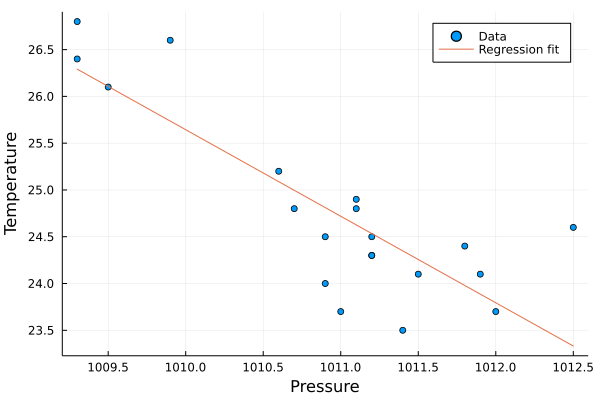

In [243]:
scatter(x, y, label = "Data", xlabel = "Pressure", ylabel = "Temperature")
ŷ = a .+ b .* x
plot!(x, ŷ, label = "Regression fit")

The intercept $a$ is the temperature value at when there is zero pressure.
The slope $b$ is the way the temperature changes as the pressure increases.

The $t$ test to test if the slope is different from zero is done in the linear model output.

In [244]:
SST = sum((y .- mean(y)).^2)
SSE = sum((y .- ŷ).^2)

R² = 1 - SSE / SST
println("My R² = "*string(R²)*", model R² = "*string(r2(lin_mod)))

My R² = 0.6896498565778808, model R² = 0.6896498565778806


In [247]:
sₑ² = SSE / (n - 2)

sy²(x, x₀) = sₑ² * (1 + 1 / length(x) + (x₀ - mean(x))^2 / sum((x .- mean(x)).^2))

MSE = (1 / length(y)) * SSE 
sy²MSE(x, x₀) = MSE * (1 + 1 / length(x) + (x₀ - mean(x))^2 / sum((x .- mean(x)).^2))

prob_y_se = sy²(x, 1013) * 2
prob_y_MSE = sy²MSE(x, 1013) * 2

println("Using sₑ² p = "*string(prob_y_se)*", using MSE p = "*string(prob_y_MSE))

Using sₑ² p = 0.840370670816886, using MSE p = 0.7563336037351974


### Question two

In [239]:
SSE = 318.274 - 316.6065

Sₑ² = SSE / 25

316.6065 / 26

1 - SSE/318.274

0.9947608035843329

### Question four

In [251]:
pois_pred(pres, temp) = exp(499.4 - 0.512 * pres + 0.76 * temp) 

precip_1956 = pois_pred(df_A3[6, :Pressure_mb], df_A3[6, :Temperature])
println("Predicited precipitation = "*string(precip_1956))

Predicited precipitation = 1.1429355539759358


## Discrimination and classification

Classify data from `df_A3` as either El nino or not based on temperature and pressure.

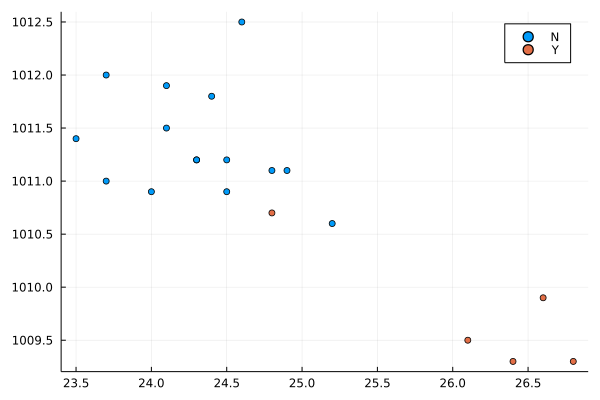

In [68]:
scatter(df_A3[:, :Temperature], df_A3[:, :Pressure_mb],  group = df_A3[:, :El_NinoYN])

Now get the two groups (Y/N).

In [173]:
Y = findall(df_A3[:, :El_NinoYN] .== "Y")
N = findall(df_A3[:, :El_NinoYN] .== "N")
x₁ = Matrix(df_A3[Y, [:Temperature, :Pressure_mb]])
n₁ = length(x₁)
x₂ = Matrix(df_A3[N, [:Temperature, :Pressure_mb]])
n₂ = length(x₂)

n = n₁ + n₂

x̄₁ = mean(x₁, dims = 1)
S₁ = cov(x₁)
x̄₂ = mean(x₂, dims = 1)
S₂ = cov(x₂)


Sₚ = @. ((n₁ - 1) / (n - 2)) * S₁ + ((n₂ - 1) / (n - 2)) * S₂
Sₚ⁻¹ = inv(Sₚ)

a = (x̄₁ - x̄₂) * Sₚ⁻¹

m = @. 0.5 * (sum(a * x̄₁) + sum(a * x̄₂))

δ₁1 = a * x₁'
δ₁2 = a * x₂'

1×15 Matrix{Float64}:
 -3655.53  -3656.65  -3660.87  -3657.46  …  -3655.06  -3659.28  -3651.58

I have not been able to get the above to work for Fisher's linear discriminant.

### Conditional probabilities

Calculating posterior probabilities from conditional and prior.

In [179]:
tp = 0.0152 * 0.162 + 0.4877 * 0.162
(0.0152 * 0.162) / tp

0.030224696758798963

## Clustering

Fair to say I am not on top of this stuff so will need to revisit clustering again.
Compute distance matrix using Karl-Pearson distance for table A.3.
Use the correlation matrix here.

In [3]:
X = Matrix(df_A3[15:end, [:Temperature, :Pressure_mb]])
d = zeros(6, 6)
s = cor(X, dims = 2)

for i in 1:length(X[:, 1])
    for j in 1:length(X[:, 2])
        d[i, j] = sqrt( sum([(1 / s[k, k]) * (X[i, k] - X[j, k])^2 for k in 1:2]))
    end
end

d

6×6 Matrix{Float64}:
 0.0       3.28024   2.16333   2.90689   0.632456  1.56525
 3.28024   0.0       1.41421   0.728011  3.8833    1.99249
 2.16333   1.41421   0.0       0.806226  2.69072   0.640312
 2.90689   0.728011  0.806226  0.0       3.46554   1.44222
 0.632456  3.8833    2.69072   3.46554   0.0       2.06155
 1.56525   1.99249   0.640312  1.44222   2.06155   0.0

Now look at various clustering methods.

Here is what the `Hclust` type looks like:

```julia
struct Hclust{T<:Real}
    merges::Matrix{Int} # the tree merge sequence. 1st column: left subtree, 2nd column: right subtree
    heights::Vector{T}  # subtrees heights (aggregated distance between its elements)
    order::Vector{Int}  # the order of datapoint (leaf node) indices in the final tree
    linkage::Symbol     # subtree distance type (cluster linkage)
end
```

and to plot the dendogram need to use `StatsPlots`.
Hard to gain real info from the dendogram.

Main thing is to note the change in the y-axis which is **distance** using the chosen metric.
The dendograms start with 6 cluseters (there are six data points) then joins until there is just one group.
Not sure if I can do the centroid method or the Ward method on the raw data with this package.

### Single linkage

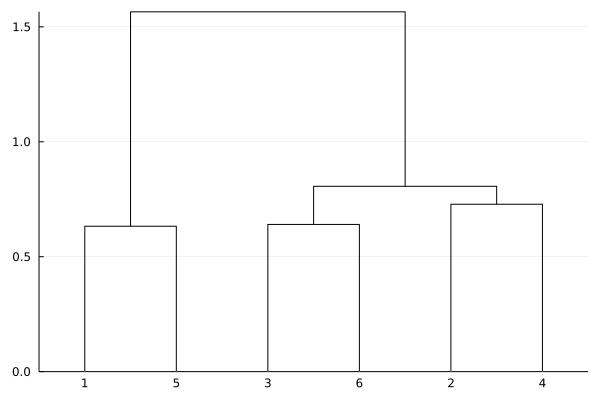

In [75]:
sl_clust = hclust(d; linkage = :single)
plot(sl_clust)

### Complete linkage

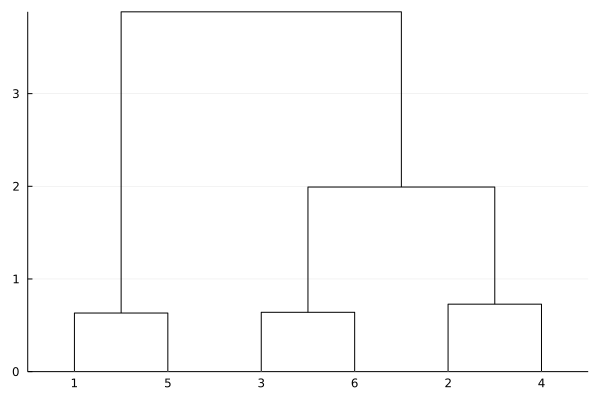

In [14]:
cp_clust = hclust(d; linkage = :complete)
plot(cp_clust)

### Average linkage

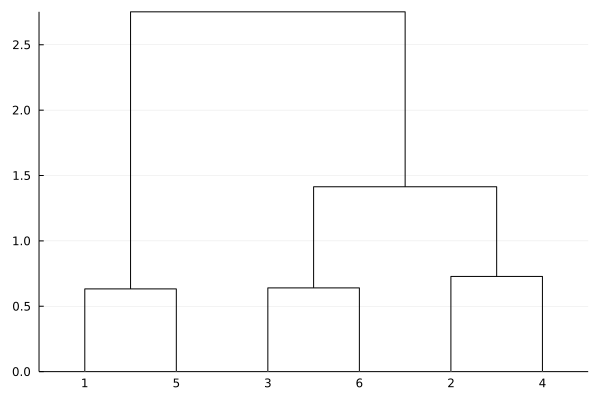

In [77]:
av_clust = hclust(d; linkage = :average)
plot(av_clust)

### K means

Using initial groups $G_{1} = \{1965, 1966, 1967\}$ and $G_{2} = \{1968, 1969, 1970\}$.

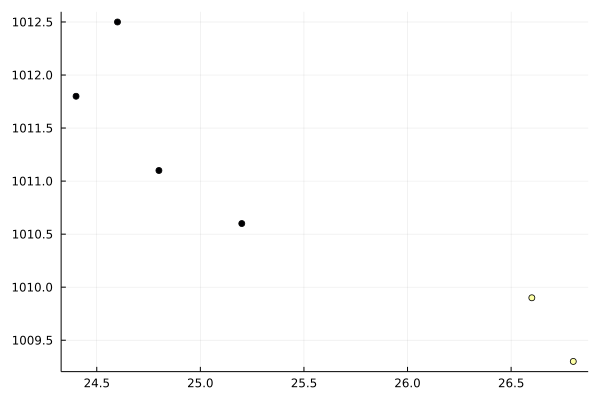

In [10]:
group = [1, 1, 1, 2, 2, 2]
X = [X group]

result = kmeans(X', 2)

scatter(X[:, 1], X[:, 2], marker_z = result.assignments, colorbar = false, label = false)